In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical
from collections import deque

In [2]:
env = gym.make('CartPole-v0')

In [3]:
print(f'action space: {env.action_space}')
print(f'state space: {env.observation_space}')

action space: Discrete(2)
state space: Box(4,)


In [4]:
class Policy(nn.Module):
    
    def __init__(self, action_space, state_space):
        
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_space, 16)
        self.fc2 = nn.Linear(16, action_space)
        
    def forward(self, state):
        
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        
        return F.softmax(x, dim = 1)
    
    def act(self, state):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to('cuda:0')
        x = self.forward(state).cpu()
        m = Categorical(x)
        action = m.sample()
        
        return action.item(), m.log_prob(action)

In [14]:
model = Policy(2, 4).to('cuda:0')
optimizer = optim.Adam(model.parameters(), lr = 1e-2)

GAMMA = 1.0
score_deque = deque(maxlen=100)
scores = []

for episode in range(1, 2001):
    
    saved_log_samples = []
    rewards = []    
    
    state = env.reset()
    
    for i in range(1000):
    
        action, log_prob = model.act(state)
        state, reward, done, _ = env.step(action)
        saved_log_samples.append(log_prob)
        rewards.append(reward)
        
        if done:
            break
    
    score_deque.append(sum(rewards))
    scores.append(sum(rewards))
    
    discounts = [GAMMA**i for i in range(len(rewards) +1)]
    R = sum([r*d for r,d in zip(rewards,discounts)])
    
    log_probs = []
    for log_prob in saved_log_samples:
        log_probs.append(-log_prob * R)    
    log_probs = torch.cat(log_probs).sum()

    optimizer.zero_grad()
    log_probs.backward()
    optimizer.step()
    
    if episode % 100 == 0:
        print('Episode {}\tAverage Score: {:.2f}'.format(episode, np.mean(score_deque)))
        
    if np.mean(score_deque)>=195.0:
        print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, np.mean(score_deque)))
        
        break

Episode 100	Average Score: 22.36
Episode 200	Average Score: 28.03
Episode 300	Average Score: 39.22
Episode 400	Average Score: 87.95
Episode 500	Average Score: 135.43
Episode 600	Average Score: 145.07
Environment solved in 584 episodes!	Average Score: 195.11


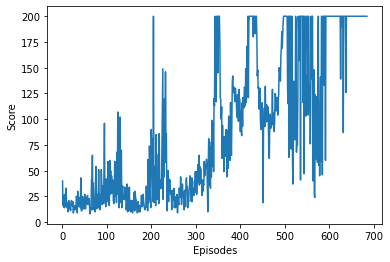

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()

plt.plot(np.arange(1, len(scores)+1), scores)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.show()